In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append("/home/darth/projects/bopt")
sys.path.append("/Users/arnoljak/projects/bopt")

import numpy as np
import random
import matplotlib.pyplot as plt

from numpy.linalg import solve, cholesky, inv
from numpy.random import multivariate_normal

from functools import partial

%matplotlib inline

import bopt

from bopt.kernels import SquaredExp, RationalQuadratic, Linear, Matern
from bopt.gaussian_process import GaussianProcess
from bopt.bayesian_optimization import bo_plot_exploration, bo_maximize_loop, Integer, Float
from bopt.bayesian_optimization import plot_2d_optim_result
from bopt.acquisition_functions import expected_improvement, probability_of_improvement
from bopt.bayesian_optimization import propose_location
from bopt.opt_functions import get_opt_test_functions
from bopt.plot import plot_gp, plot_kernel_loss, plot_kernel_loss_2d

import GPy
import sklearn.gaussian_process as skproc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/arnoljak/projects/GPy/GPy/util/config.py:28: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/arnoljak/projects/GPy/GPy/defaults.cfg' mode='r' encoding='UTF-8'>
  config.readfp(open(default_file))
/Users/arnoljak/projects/GPy/GPy/util/datasets.py:58: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/arnoljak/projects/GPy/GPy/util/data_resources.json' mode='r' encoding='utf-8'>
  json_data = open(path, encoding='utf-8').read()
/Users/arnoljak/projects/GPy/GPy/util/datasets.py:63: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/arnoljak/projects/GPy/GPy/util/football_teams.json' mode='r' encoding='utf-8'>
  json_data = open(path, encoding='utf-8').read()
/Users/arnoljak/.pyenv/versions/3.6.7/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/arnoljak/.pyenv/versions/3.6.7/Python.fra

## Broken kernel


In [2]:
def kernel_plot(lbfgs = False, use_tf = False):
    bopt.clear_param_traces()
    os.environ["USE_LBFGS"] = "1" if lbfgs else "0"
    os.environ["USE_TF"] = "1" if use_tf else "0"

    gp = bopt.GaussianProcess(kernel=result.kernel) \
        .fit(X, y) \
        .optimize_kernel()
    
    plt.figure(figsize=(16, 5))
    U_LB = os.environ.get("USE_LBFGS", False)
    U_TF = os.environ.get("USE_TF", False)

    plt.suptitle(f"LBFGS={U_LB} TF={U_TF}   noise={round(gp.noise, 2)} {gp.kernel}", fontsize=20)

    plt.subplot(131)
    bopt.plot_2d_optim_result(result, gp=gp)
    
    param_traces = bopt.kernel_opt.get_param_traces()

    nll_trace = param_traces["nll"]
    param_traces.pop("nll")

    plt.subplot(132)
    for name, vals in param_traces.items():
        plt.plot(vals, label=name)
    plt.subplot(133)
    plt.plot(nll_trace)
    plt.show()

...le=0.91 si=1.21 0.5566065935213983 nll=16.32


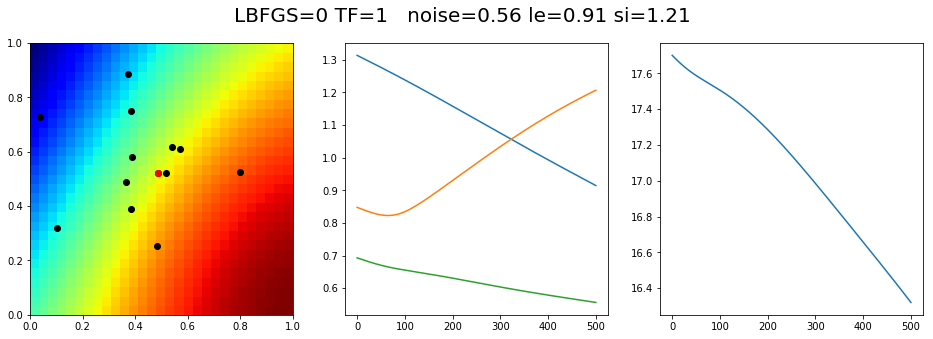

W0204 17:45:29.355273 140735599186816 deprecation.py:323] From /Users/arnoljak/projects/bopt/.venv/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3532: setdiff1d (from tensorflow.python.ops.array_ops) is deprecated and will be removed after 2018-11-30.
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


...le=0.25 si=0.77 0.3026295390592803 nll=9.36


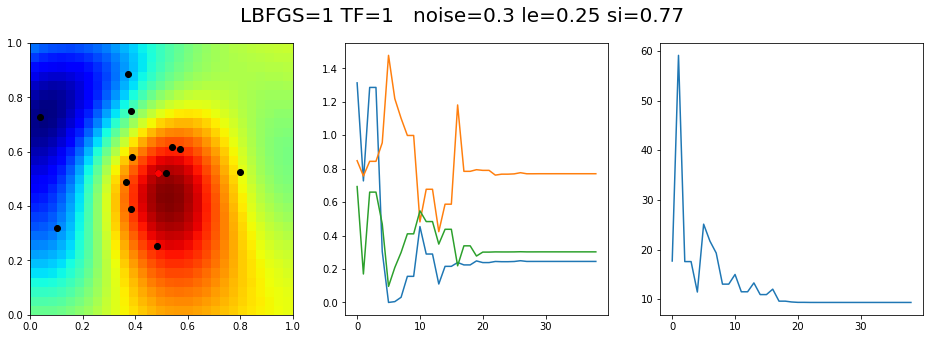

...le=0.25 si=0.77 0.3026295231047308 nll=9.36


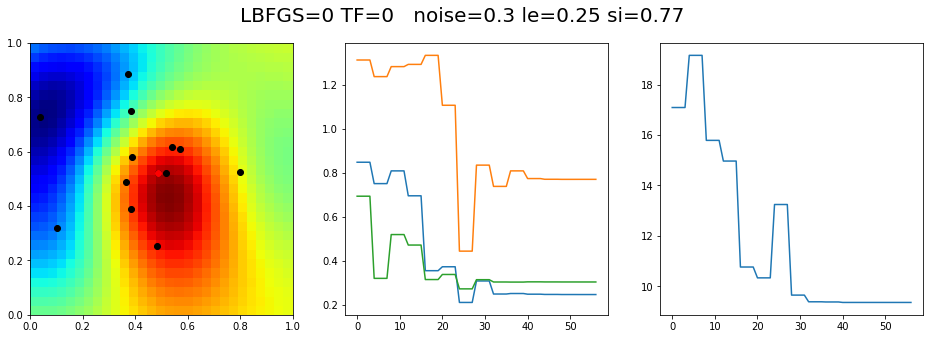

In [3]:
exp = bopt.Experiment.deserialize("results/mc")
result = exp.current_optim_result()

X = result.X_sample
y = result.y_sample

y = (y - y.mean()) / y.std()

kernel_plot(use_tf=True, lbfgs=False)
kernel_plot(use_tf=True, lbfgs=True)
kernel_plot(use_tf=False)

# 1d comparison with GPy

In [23]:
def model_bopt():
    gp = GaussianProcess(noise=1.0, kernel=SquaredExp(l=1.0, sigma=1.0)).fit(X_train, y_train)\
      .optimize_kernel().posterior(X)
    
    params = {
        "noise": gp.noise,
        "ls": gp.kernel.params["lengthscale"].numpy().item(),
        "sigma": gp.kernel.params["sigma"].numpy().item()
    }
    
    print(params)
    return gp.mu, gp.cov, params, gp.log_prob().numpy().item()

    
def model_gpy():
    # {'noise': 0.4832512948800222, 'ls': 1.5587106910395732, 'sigma': 3.8447816296081188}
    rbf = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
    gpr = GPy.models.GPRegression(X_train, y_train.reshape(-1, 1), rbf)

    gpr.optimize(max_iters=5000)
    print("####################################\n\n")
    
    mu, cov = gpr.predict(X, full_cov=True)
    
    params = {
        "noise": float(np.sqrt(gpr.Gaussian_noise.variance)),
        "ls": gpr.rbf.lengthscale.values[0],
        "sigma": np.sqrt(gpr.rbf.variance.values[0])
    }
    
    nll = -gpr.log_likelihood()
    
    print(params)
    return mu.reshape(-1), cov, params, nll

In [29]:
params = [0.1, 0.3]

X_train = np.array([2,2.5,20,100], dtype=np.float64).reshape(-1, 1)
y_train = np.array([2,3,2,5], dtype=np.float64)

X = np.arange(min(X_train) - 0.1, max(X_train) + 0.1, step=0.1).reshape(-1, 1)

{'noise': 0.7960131194331123, 'ls': 161.87495527735706, 'sigma': 3.867488614536164}



####################################


GPY
[[14.95018676 14.95018962 14.95018676 14.9501782  14.95016393]
 [14.95008685 14.95011825 14.95014395 14.95016393 14.9501782 ]
 [14.85696351 14.85798762 14.85900612 14.86001901 14.8610263 ]
 [12.44069747 12.44535649 12.45001251 12.45466551 12.45931549]]
[[-0.45062249]
 [ 1.10843779]
 [-1.16110707]
 [ 0.77963083]]
(4, 982) (4, 1)
{'noise': 0.7959051924751367, 'ls': 161.8226667723994, 'sigma': 3.8665475062518815}


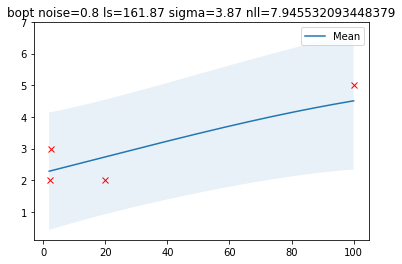

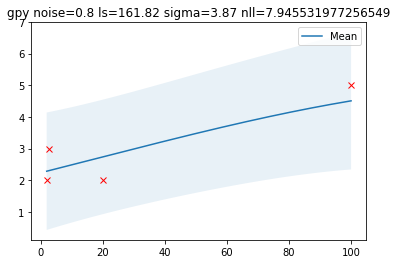

In [30]:
xxx = model_bopt()
print("\n\n")
yyy = model_gpy()

model_options = [
    ("bopt", xxx),
    ("gpy", yyy)
]

for name, (mu, cov, params, nll) in model_options:
#     mu, cov, params = model()

    param_str = " ".join([f"{name}={round(value, 2)}" for name, value in params.items()])
    
    plt.figure()
    plt.title(name + " " + param_str + f" nll={nll}")
    plot_gp(mu.reshape(-1), cov, X.reshape(-1), X_train.reshape(-1),
            y_train.reshape(-1), num_samples=0, figure=False)

In [21]:
GaussianProcess(noise=1.48, kernel=SquaredExp(l=1.56, sigma=3.84)).fit(X_train, y_train)\
      .log_prob()

<tf.Tensor: id=44953, shape=(), dtype=float64, numpy=7.450307651662683>

GPY
[[8.87858362 8.89965706 8.92018708 8.94016566 8.95958485]
 [7.53252763 7.56928243 7.60585532 7.64223907 7.67842638]
 [5.82230126 5.86109141 5.89993989 5.93884298 5.97779688]
 [4.21044785 4.24394593 4.27760363 4.31141984 4.34539336]]
[[-0.10147488]
 [-0.72181399]
 [ 1.64123392]
 [-0.45945228]]
(4, 200) (4, 1)
GPY
[[8.87858362 8.89965706 8.92018708 8.94016566 8.95958485]
 [7.53252763 7.56928243 7.60585532 7.64223907 7.67842638]
 [5.82230126 5.86109141 5.89993989 5.93884298 5.97779688]
 [4.21044785 4.24394593 4.27760363 4.31141984 4.34539336]]
[[-0.10147488]
 [-0.72181399]
 [ 1.64123392]
 [-0.45945228]]
(4, 200) (4, 1)
GPY
[[8.87858362 8.89965706 8.92018708 8.94016566 8.95958485]
 [7.53252763 7.56928243 7.60585532 7.64223907 7.67842638]
 [5.82230126 5.86109141 5.89993989 5.93884298 5.97779688]
 [4.21044785 4.24394593 4.27760363 4.31141984 4.34539336]]
[[-0.10147488]
 [-0.72181399]
 [ 1.64123392]
 [-0.45945228]]
(4, 200) (4, 1)


{'dataplot': [<matplotlib.collections.PathCollection at 0x110779a20>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x110779da0>],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x110779128>]}

 /Users/arnoljak/projects/bopt/.venv/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


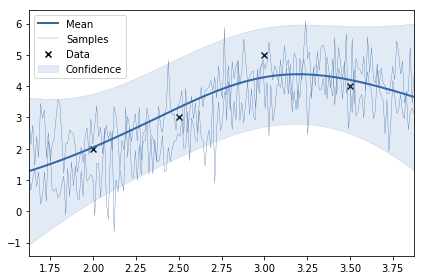

In [15]:
# rbf = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
rbf = GPy.kern.Matern52(input_dim=1)
gpr = GPy.models.GPRegression(X_train, y_train.reshape(-1, 1), rbf)

gpr.optimize()
gpr.plot(samples=2)

{'noise': 0.4832485485668914, 'ls': 1.558718823156938, 'sigma': 3.844799807952887}


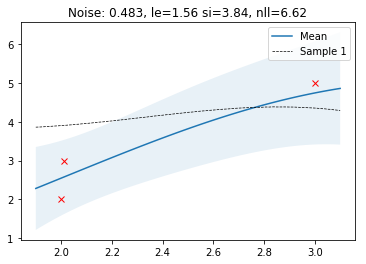

In [61]:
def gpy_to_bopt():
    _, _, gpy_params, nll = model_gpy()

    gp = GaussianProcess(noise=gpy_params["noise"],
                     kernel=SquaredExp(l=gpy_params["ls"], sigma=gpy_params["sigma"]))\
      .fit(X_train, y_train)
    
    return gp

# BOPT plot using exactly the same GPY params
gpy_to_bopt().posterior(X).plot_posterior(figsize=(6,4), num_samples=1)

In [91]:
m1.shape, m2.shape, c1.shape, c2.shape

((121,), (121,), (121, 121), (121, 121))

In [59]:
np.allclose(c1, c2, atol=1e-5), np.allclose(m1, m2, atol=1e-5)

(True, True)

####################################


GPY
[[14.75209525 14.7578646  14.76302856 14.7675865  14.77153785]
 [14.74572123 14.75209525 14.7578646  14.76302856 14.7675865 ]
 [11.52399446 11.57604925 11.62786056 11.67942305 11.73073135]]
[[-1.13529118]
 [ 0.87894457]
 [ 0.52674849]]
(3, 121) (3, 1)
{'noise': 0.4832485485668914, 'ls': 1.558718823156938, 'sigma': 3.844799807952887}
{'noise': 0.4832512948800222, 'ls': 1.5587106910395732, 'sigma': 3.8447816296081188}
max mean diff 3.0862499329487036e-06
nll diff 2.099564966329126e-11

c diff 5.286232653611833e-06


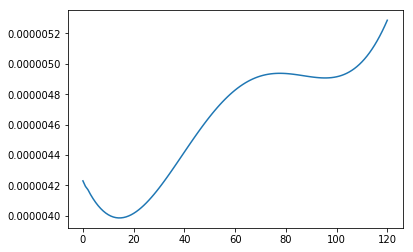

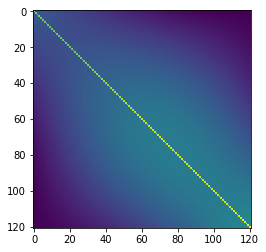

array([4.22987232e-06, 4.19371103e-06, 4.17133708e-06, 4.14028927e-06,
       4.11297620e-06, 4.08854893e-06, 4.06693691e-06, 4.04806741e-06,
       4.03186571e-06, 4.01825520e-06, 4.00715751e-06, 3.99849264e-06,
       3.99217909e-06, 3.98813401e-06, 3.98627332e-06, 3.98651186e-06,
       3.98876351e-06, 3.99294134e-06, 3.99895771e-06, 4.00672448e-06,
       4.01615308e-06, 4.02715465e-06, 4.03964023e-06, 4.05352084e-06,
       4.06870763e-06, 4.08511200e-06, 4.10264578e-06, 4.12122130e-06,
       4.14075156e-06, 4.16115034e-06, 4.18233232e-06, 4.20421321e-06,
       4.22670990e-06, 4.24974050e-06, 4.27322458e-06, 4.29708316e-06,
       4.32123890e-06, 4.34561617e-06, 4.37014119e-06, 4.39474211e-06,
       4.41934908e-06, 4.44389444e-06, 4.46831271e-06, 4.49254074e-06,
       4.51651778e-06, 4.54018557e-06, 4.56348840e-06, 4.58637319e-06,
       4.60878961e-06, 4.63069002e-06, 4.65202973e-06, 4.67276685e-06,
       4.69286247e-06, 4.71228069e-06, 4.73098867e-06, 4.74895661e-06,
      

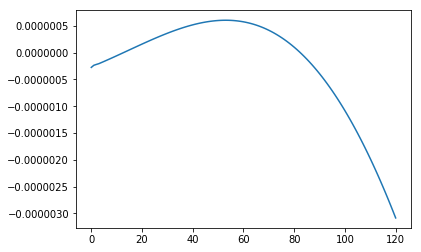

In [55]:
m2, c2, _, nll2 = model_gpy()
m1, c1, _, nll1 = model_bopt()

print("max mean diff", np.max(np.abs(m1 - m2)))
print("nll diff", np.max(np.abs(nll1 - nll2)))
print()
print("c diff", np.max(np.abs(c1 - c2)))
plt.plot(np.diag(c1 - c2))
plt.show()
plt.imshow(c1 - c2)
plt.show()

plt.plot(m1 - m2)
np.diag(c1 - c2)

## 2d data - BOPT vs GPY

...le=0.25 si=1.09 0.4279884328731872 nll=15.16


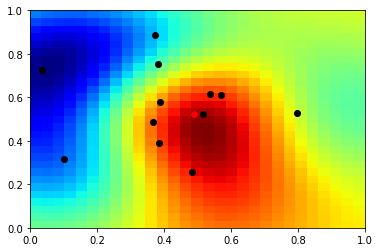

-15.159323768954888
...le=0.25 si=1.09 0.1831693041752468 nll=21.34


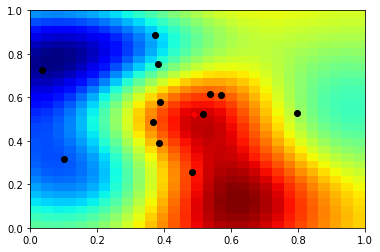

In [61]:
exp = bopt.Experiment.deserialize("results/mc")
result = exp.current_optim_result()

X_train = result.X_sample
y_train = result.y_sample

y_train = (y_train - y_train.mean()) / y_train.std()

model_options = [
    ("bopt", model_bopt),
    ("gpy", model_gpy)
]

gp = bopt.GaussianProcess(kernel=result.kernel) \
    .fit(X_train, y_train) \
    .optimize_kernel()

bopt.plot_2d_optim_result(result, gp=gp)
plt.show()

rbf = GPy.kern.RBF(input_dim=2, variance=1.0, lengthscale=1.0)
gpr = GPy.models.GPRegression(X_train, y_train.reshape(-1, 1), rbf)

gpr.optimize()
print(gpr.log_likelihood())

gpy_params = {
    "noise": float(gpr.Gaussian_noise.variance),
    "ls": gpr.rbf.lengthscale.values[0],
    "sigma": np.sqrt(gpr.rbf.variance.values[0])
}

gp = GaussianProcess(noise=gpy_params["noise"],
                     kernel=SquaredExp(l=gpy_params["ls"], sigma=gpy_params["sigma"]))\
        .fit(X_train, y_train)

bopt.plot_2d_optim_result(result, gp=gp)
plt.show()

# for name, model in model_options:
#     mu, cov, params = model()
    
#     param_str = " ".join([f"{name}={round(value, 2)}" for name, value in params.items()])
    
#     plt.figure()
#     plt.title(name + " " + param_str)
# #    plot_gp(mu.reshape(-1), cov, X.reshape(-1), X_train.reshape(-1),
# #            y_train.reshape(-1), num_samples=1, figure=False)

-24.077623531994096


 /home/darth/projects/bopt/.venv/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x7f1c9132e5f8>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x7f1c9132e668>]}

 /home/darth/projects/bopt/.venv/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


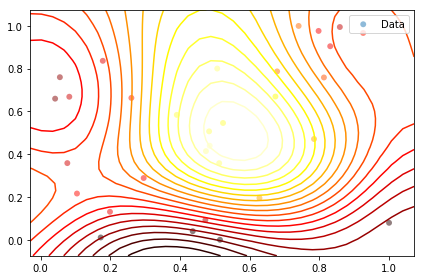

In [255]:
rbf = GPy.kern.RBF(input_dim=2, variance=1.0, lengthscale=1.0)
gpr = GPy.models.GPRegression(X_train, y_train.reshape(-1, 1), rbf)

gpr.optimize()
print(gpr.log_likelihood())

gpr.plot()

In [ ]:
## useless

def model_sklearn():
    rbf = skproc.kernels.ConstantKernel(1.0) \
            * skproc.kernels.RBF(length_scale=1.0) \
            * skproc.kernels.WhiteKernel(1.0)

    gpr = skproc.GaussianProcessRegressor(kernel=rbf, alpha=1.)
    gpr.fit(X_train.reshape(-1, 1), y_train.reshape(-1, 1))

    mu, cov = gpr.predict(X.reshape(-1, 1), return_cov=True)

    kernel_sigma = gpr.kernel_.k1.k1
    kernel_ls = gpr.kernel_.k1.k2
    kernel_noise = gpr.kernel_.k2
    
    params = {
        "noise": kernel_noise.noise_level,
        "ls": kernel_ls.length_scale,
        "sigma": np.sqrt(kernel_sigma.constant_value)
    }
    
    return mu, cov, params

In [10]:
rbf.K(X_train.reshape(-1, 1), X_train.reshape(-1, 1))

array([[14.78248556, 14.78218135, 12.03294434],
       [14.78218135, 14.78248556, 12.0823241 ],
       [12.03294434, 12.0823241 , 14.78248556]])

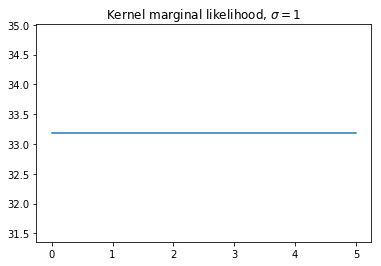

In [11]:
class GPyWrapper:
    def __init__(self):
        self.params = None
        
    def set_params(self, params):
        self.params = params
        return self
        
    def __call__(self, a, b):
        return GPy.kern.RBF(input_dim=1, variance=1., lengthscale=params[0]).K(a.reshape(-1, 1), b.reshape(-1, 1))

plot_kernel_loss(GPyWrapper(), X_train, y_train)

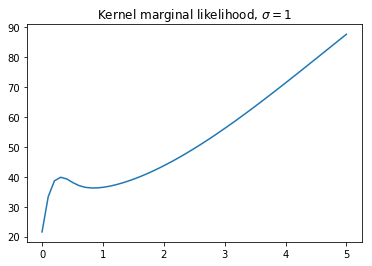

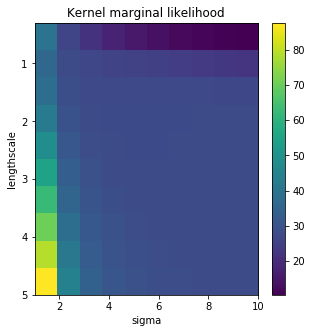

In [12]:
kernel = SquaredExp(sigma=0.001)
plot_kernel_loss(kernel, X_train, y_train)
plot_kernel_loss_2d(kernel, X_train, y_train)

# Big data

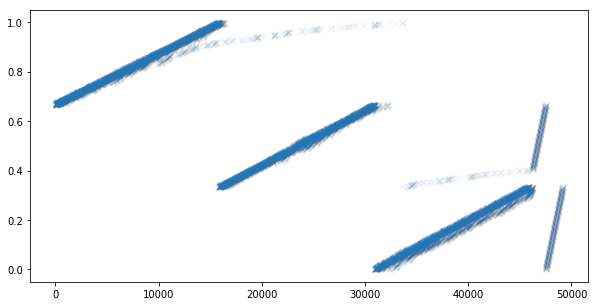

In [15]:
values = np.genfromtxt("../data/matmul_faults.txt", converters={0:lambda s: int(s, 16)}, dtype=np.int64)
from sklearn.preprocessing import MinMaxScaler
values = MinMaxScaler().fit_transform(values.reshape(-1, 1).astype(np.float64))

plt.figure(figsize=(10,5))
plt.plot(values, "x", alpha=0.01)

In [16]:
offset = 0
num = 500
X = np.array(list(range(len(values))))[offset:offset + num]
y = values[offset:offset + num].reshape(-1)

y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))

In [17]:
def fit_with_scale(X, y, scale):
    y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
    X = np.array(list(range(len(y)))) / scale

    gp = GaussianProcess(kernel=SquaredExp(), noise=1).fit(X, y).optimize_kernel().posterior(X)
    gp.plot_posterior(num_samples=0)


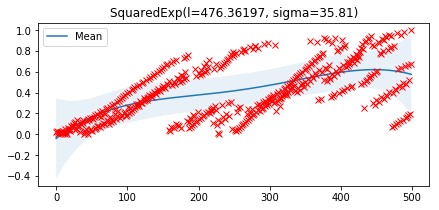

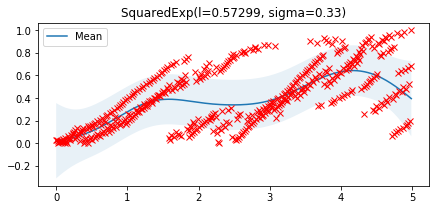

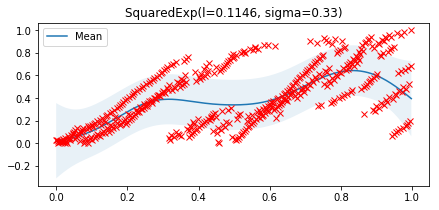

In [18]:
def foo():
    for i in [1,100, 500]:
        fit_with_scale(X, y, i)
        plt.show()
        
%prun foo()

# TODO Gaussian likelihood for a given covariance

# TODO Gaussian likelihood for a given covariance

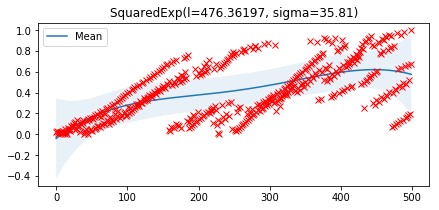

In [19]:
y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))

gp = GaussianProcess(kernel=SquaredExp(), noise=1).fit(X, y).optimize_kernel().posterior(X)
gp.plot_posterior(num_samples=0)

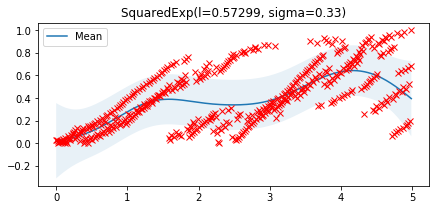

In [20]:
y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))/100

gp = GaussianProcess(kernel=SquaredExp(), noise=1).fit(X, y).optimize_kernel().posterior(X)
gp.plot_posterior(num_samples=0)

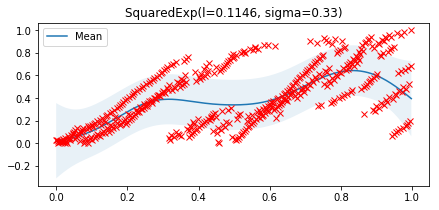

In [21]:
y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))/500

gp = GaussianProcess(kernel=SquaredExp(), noise=1).fit(X, y).optimize_kernel().posterior(X)
gp.plot_posterior(num_samples=0)

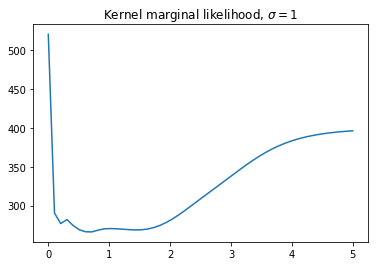

In [22]:
offset = 0
num = 500
X = np.array(list(range(len(values))))[offset:offset + num]
y = values[offset:offset + num].reshape(-1)

y = MinMaxScaler().fit_transform(y.reshape(-1,1).astype(np.float64)).reshape(-1)
X = np.array(list(range(len(y))))/100

plot_kernel_loss(SquaredExp(), X, y)

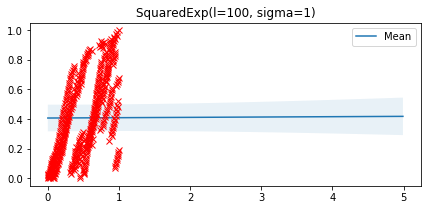

In [23]:
gp.with_kernel_params([100,1]).posterior(X).plot_posterior(num_samples=0)

## Stare data

In [138]:
noise = 1

params = [0.1, 0.3]#, 0.6, 0.9]

#X_train = np.array([0, 0.02, 0.05, 0.3, 0.4,1,1.1,1.2,1.3,1.4,2,3,4])

X_train = np.array([2,2.01,3], dtype=np.float64).reshape(-1, 1)  #, 0.02, 0.05, 0.3, 0.4,1,2,3,4])
y_train = np.array([2,3,5], dtype=np.float64)

# X_train = np.array([2,2.01,2.02,3])#, 0.02, 0.05, 0.3, 0.4,1,2,3,4])
# y_train = np.array([2,3,2,100])

# y_train[1] = .6
# y_train[2] = 1

X = np.arange(min(X_train) - 0.1, max(X_train) + 0.1, step=0.01).reshape(-1, 1)